In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import numpy as np
import cv2 as cv
from PIL import Image
import os
import matplotlib.pyplot as plt
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

#Face Segmentation

In [ ]:
!pip install mtcnn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 22.4 MB/s eta 0:00:00


In [ ]:
base_dir = '/content/drive/MyDrive/Capstone/Season'

In [ ]:
season_names = os.listdir(base_dir)
season_dir = [os.path.join(base_dir, season) for season in season_names ]
file_path = []

for season in season_dir:
  for file_name in os.listdir(season):
    file_path.append(os.path.join(season, file_name))

In [ ]:
def showImages(image_list, length = 10):
  fig, axes = plt.subplots(length // 5, 5, figsize=(12, 8))

  for i in range(length):
    axes[i//5, i%5].imshow(image_list[i])
  plt.show()

In [ ]:
# Import all of the images
image_list = []

for _file in file_path:
  img = cv.imread(_file)
  img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
  image_list.append(img)

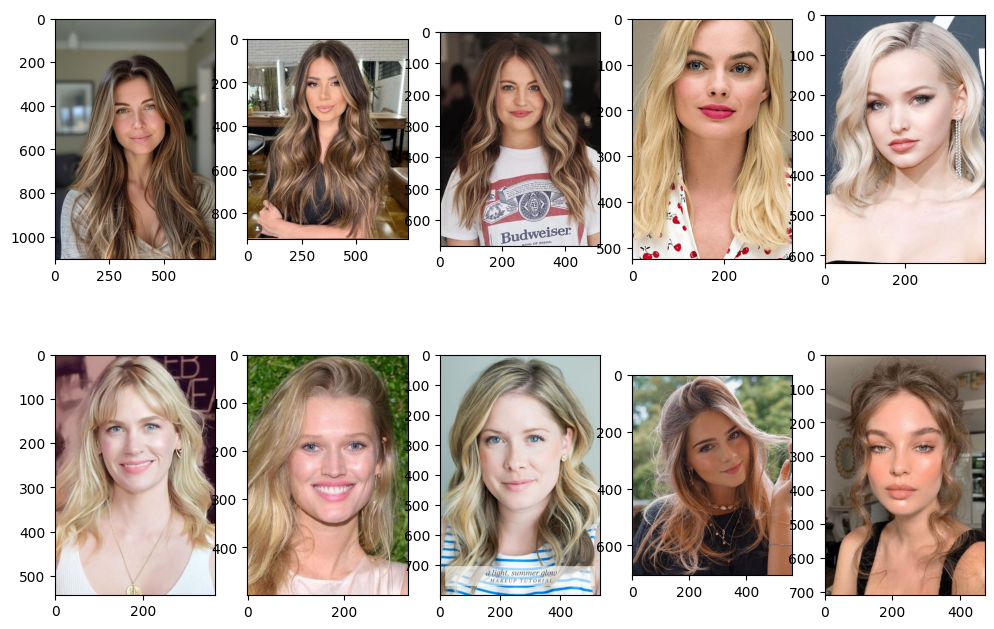

In [ ]:
showImages(image_list)

In [ ]:
from mtcnn.mtcnn import MTCNN

result = []

detector = MTCNN()
for i in range(len(image_list)):
  result.append(detector.detect_faces(image_list[i]))
  print(f'{i+1}/{len(image_list)} image done!')

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 18ms/step
747/1103 image done!
1/1 [==============================] - 0s 19ms/step
748/1103 image done!
1/1 [==============================] - 0s 37ms/step
749/1103 image done!
1/1 [==============================] - 0s 30ms/step
750/1103 image done!
1/1 [==============================] - 0s 52ms/step
751/1103 image done!
1/1 [==============================] - 0s 19ms/step
752/1103 image done!
1/1 [==============================] - 0s 18ms/step
753/1103 image done!
1/1 [==============================] - 0s 18ms/step
754/1103 image done!
1/1 [==============================] - 0s 18ms/step
755/1103 image done!
1/1 [==============================] - 0s 18ms/step
756/1103 image done!
1/1 [==============================] - 0s 17ms/step
757/1103 image done!
1/1 [==============================] - 0s 17ms/step
758/1103 image done!
1/1 [==============================] - 0s 43ms/step
759/1103 image done!


In [ ]:
def make_square(bbox):
  x, y, width, height = bbox
  if width != height:
    max_side = max(width, height)
    x_center = x + width // 2
    y_center = y + height // 2
    x = x_center - max_side // 2
    y = y_center - max_side // 2

    # Memastikan x dan y tidak negatif
    x = max(0, x_center - max_side // 2)
    y = max(0, y_center - max_side // 2)

    width = height = max_side
  return x, y, width, height

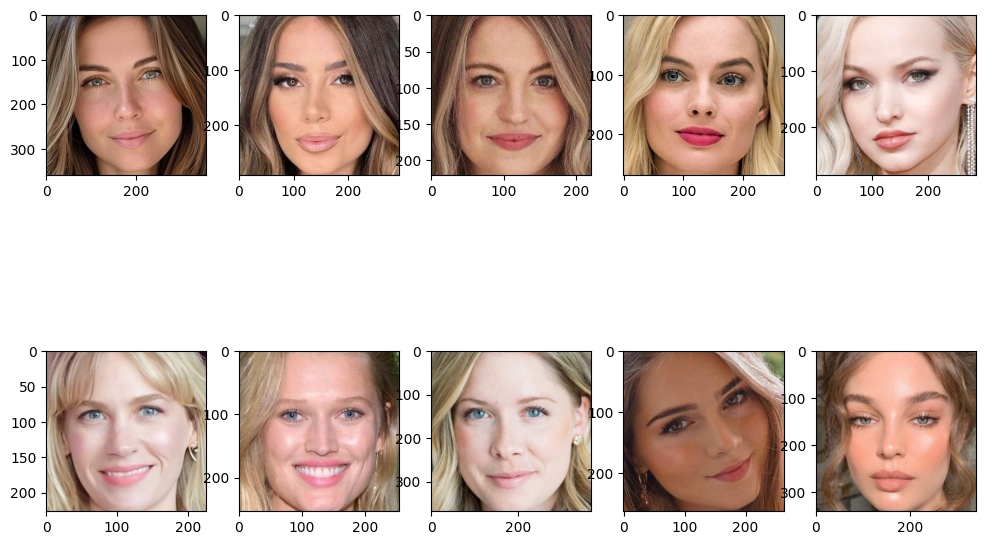

In [ ]:
image_list_segmented = []

for i in range(len(image_list)):
  x, y, width, height = make_square(result[i][0]['box'])
  image_segmented = image_list[i][y:y+height, x:x+width]
  image_list_segmented.append(image_segmented)

showImages(image_list_segmented)

In [ ]:
result_dir = base_dir + 'Segmented'
os.makedirs(result_dir, exist_ok=True)

season_path  = []
for i in range(len(season_names)):
  season_path.append(os.path.join(result_dir, season_names[i]))
  os.makedirs(season_path[i], exist_ok=True)

In [ ]:
def save_image_to_jpg(image, file_path):
  image_rgb = cv.cvtColor(image, cv.COLOR_BGR2RGB)
  cv.imwrite(file_path, image_rgb, [int(cv.IMWRITE_JPEG_QUALITY), 90])

In [ ]:
for i in range(len(file_path)):
  image_season = file_path[i].split(os.sep)[-2]
  image_name = file_path[i].split(os.sep)[-1]
  image_save_path = os.path.join(result_dir, image_season, image_name)
  save_image_to_jpg(image_list_segmented[i], image_save_path)

In [ ]:
for season in season_names:
  print(f'{season} image results count: {len(os.listdir(os.path.join(result_dir, season)))}')

Summer image results count: 252
Autumn image results count: 278
Spring image results count: 271
Winter image results count: 302


## Rename files

Optional, if you want to standardized the file names

In [ ]:
for season in season_path:
  season_file_list = os.listdir(season)
  for i in range(len(season_file_list)):
    old_file_path = os.path.join(season, season_file_list[i])
    new_file_path = os.path.join(season, f'{season}{i+1}.jpg')
    print(old_file_path)
    print(new_file_path)

    # os.rename(old_file_path, new_file_path)

print(season_path)

['/content/drive/MyDrive/Capstone/SeasonSegmented/Summer', '/content/drive/MyDrive/Capstone/SeasonSegmented/Autumn', '/content/drive/MyDrive/Capstone/SeasonSegmented/Spring', '/content/drive/MyDrive/Capstone/SeasonSegmented/Winter']


#Training

##Imports and Setup

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
import tensorflow_datasets as tfds

from sklearn.metrics import confusion_matrix

## Preprocessing

In [ ]:

# def resize_image(image_path, size):
#     image = cv2.imread(image_path)
#     resized_image = cv2.resize(image, size)
#     return resized_image



In [ ]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
directory = '/content/drive/MyDrive/Capstone/SeasonV1'

train_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='training',
                                             seed=42)

validation_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='validation',
                                             seed=42)

Found 1075 files belonging to 4 classes.
Using 860 files for training.
Found 1075 files belonging to 4 classes.
Using 215 files for validation.


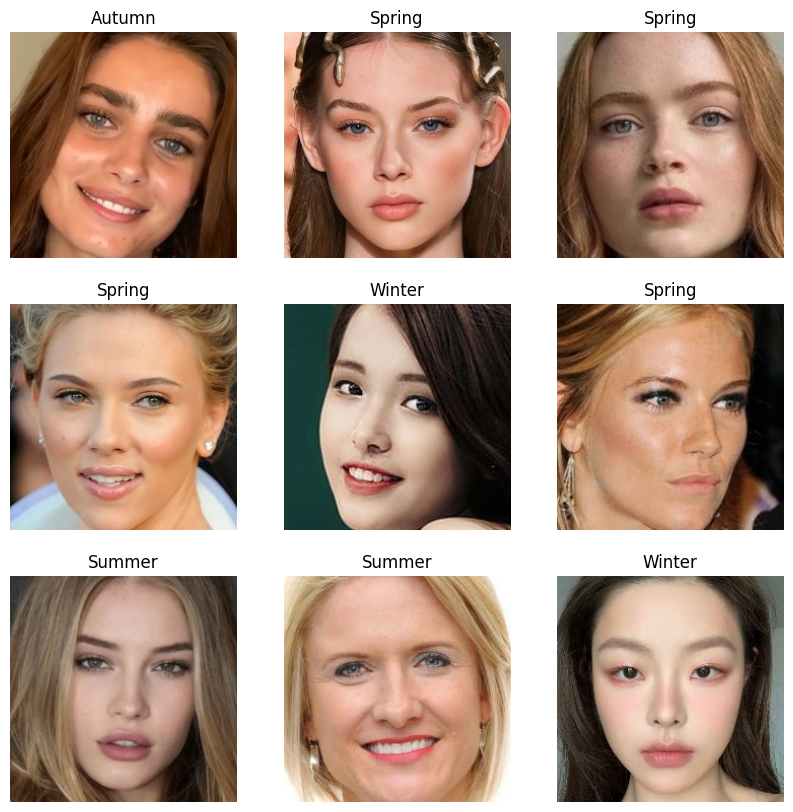

In [ ]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

Make test data by dividing the validation data

In [ ]:
# val_batches = tf.data.Dataset.cardinality(validation_dataset)
# print(val_batches)
# test_dataset = validation_dataset.take(val_batches // 5)
# validation_dataset = validation_dataset.skip(val_batches // 5)

In [ ]:
# print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
# print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

##Data Augmentation

In [ ]:
data_augmentation = tf.keras.Sequential([
    # tf.keras.layers.RandomBrightness(factor=0.2),
    # tf.keras.layers.RandomContrast(factor=0.2),
    # tf.keras.layers.RandomHue(factor=0.2),
    # tf.keras.layers.RandomSaturation(factor=0.2),
    tf.keras.layers.Rescaling(scale=1/255.)
])

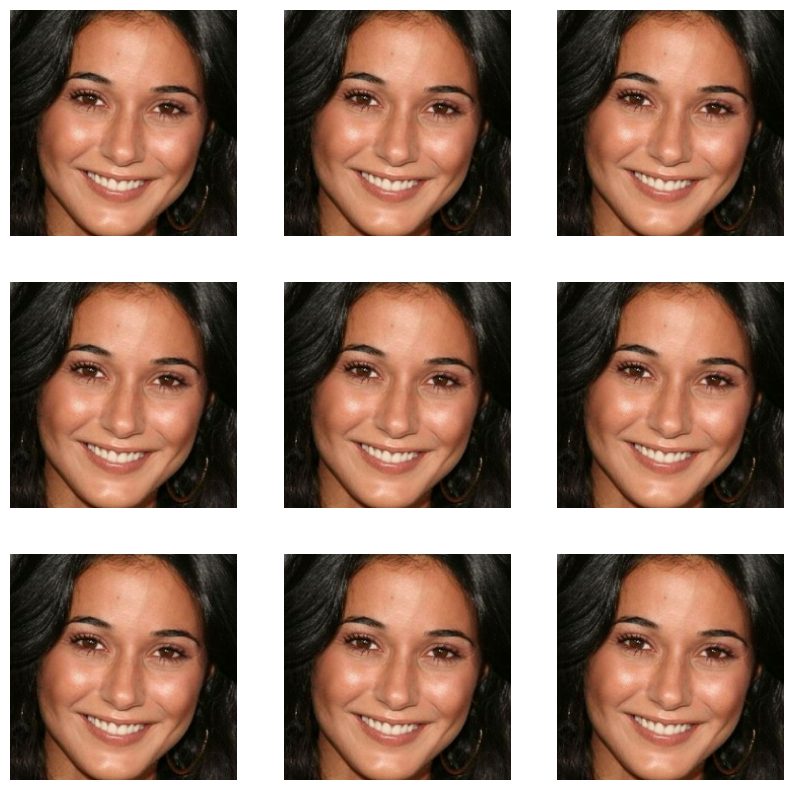

In [ ]:
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0])
        plt.axis('off')

In [ ]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 1280)


##Feature Extraction

In [ ]:
# Freeze weights for now
base_model.trainable = False

In [ ]:
base_model.summary()

Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [ ]:
prediction_layer = tf.keras.layers.Dense(4, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 4)


In [ ]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4)                   │           5,124 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,263,108 (8.63 MB)

 Trainable params: 5,124 (20.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Check the trainable variables (should be a small number)

In [ ]:
len(model.trainable_variables)

2

In [ ]:
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=validation_dataset)

Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 25s 553ms/step - accuracy: 0.3082 - loss: 1.4932 - val_accuracy: 0.5814 - val_loss: 1.0790
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 178ms/step - accuracy: 0.5167 - loss: 1.0915 - val_accuracy: 0.6372 - val_loss: 0.9626
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 0.6080 - loss: 0.9979 - val_accuracy: 0.5953 - val_loss: 0.9354
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 177ms/step - accuracy: 0.6458 - loss: 0.8769 - val_accuracy: 0.5767 - val_loss: 0.9265
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 211ms/step - accuracy: 0.6810 - loss: 0.8367 - val_accuracy: 0.6140 - val_loss: 0.8923
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 153ms/step - accuracy: 0.6937 - loss: 0.7822 - val_accuracy: 0.6233 - val_loss: 0.8739
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 154ms/step - accuracy: 0.7161 - loss: 0.7296 - val_accuracy: 0.5907 - val_loss: 0.9052
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 186ms/step - accuracy: 0.7178 - loss: 0.7384 - val_accuracy: 0

##Evaluation

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

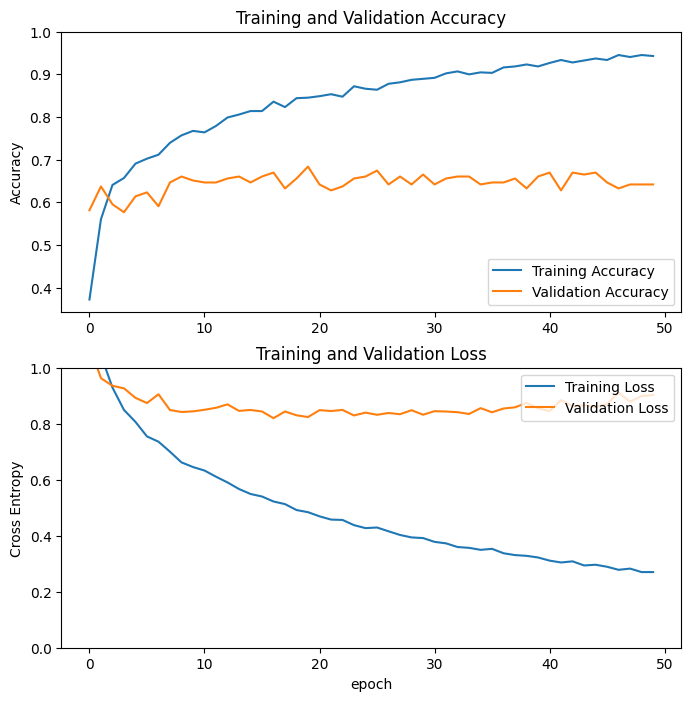

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


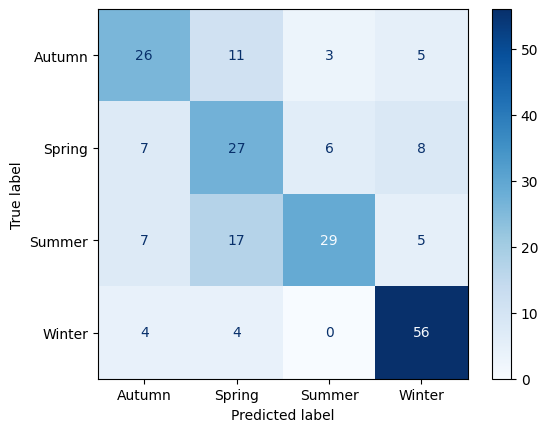

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = []
y_true = []

for images, labels in validation_dataset:
    predictions = model.predict(images)

    predicted_classes = np.argmax(predictions, axis=1)
    y_pred.extend(predicted_classes)

    true_classes = labels.numpy()
    y_true.extend(true_classes)

y_pred = np.array(y_pred)
y_true = np.array(y_true)

cm = confusion_matrix(y_true, y_pred)

class_names = validation_dataset.class_names

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.show()


## Save Model

In [ ]:
model.save('/content/drive/MyDrive/Capstone/model-season.h5')

In [ ]:
os.getcwd()

'/content'

In [ ]:
import tensorflow as tf
model_json = tf.keras.models.load_model('/content/drive/MyDrive/Capstone/model-season.h5')

In [ ]:
from tensorflow.keras.preprocessing import image
img_path = '/content/drive/MyDrive/Capstone/SeasonSegmented/Autumn/Autumn1.jpg'
img = image.load_img(img_path, target_size=(224,224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)

In [ ]:
predictions = model.predict(img_array)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


In [ ]:
print(predictions)

[[9.5997161e-01 1.5806589e-04 1.4219471e-05 3.9856181e-02]]


In [ ]:
max_confidence_index = np.argmax(predictions[0])

categories = ['Autumn', 'Spring', 'Summer', 'Winter']

predicted_category = categories[max_confidence_index]
confidence_score = predictions[0][max_confidence_index]

print(f"Predicted Category: {predicted_category} with Confidence Score: {confidence_score:.2f}")

Predicted Category: Autumn with Confidence Score: 0.96


# Convert to json

In [ ]:
!pip install tensorflowjs

In [ ]:
tf.saved_model.save(model, "/content/drive/MyDrive/Capstone/Model_h5")

In [ ]:
!tensorflowjs_converter \
    --input_format=tf_saved_model \
    --output_node_names='MobilenetV1/Predictions/Reshape_1' \
    --saved_model_tags=serve \
    /content/drive/MyDrive/Capstone/Model_h5 \
    /content/drive/MyDrive/Capstone/Model_json